# Bayes Theorem for Predicting the Probability of an Email Being Spam

S = Spam
w = Word

$P(Spam|w_{1}, w_{2},..., w_{n}) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_{i}|Spam)$

The probability that an email consisting of the words $w_{1}, w_{2},... w_{n}$ is proportional to the probability that any given email is spam multiplied by the product of each word's probability to appear in a spam email.



In [1]:
from matplotlib import pyplot as plt

import pandas as pd
import math
import time
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

pd.options.mode.chained_assignment = None  # default='warn'

PREDICTION = 'Prediction'
CLASSIFICATION = 'Classiciation'

## Functions

In [2]:
def build_confusion_matrix(data):
    confusion_matrix = {
        'email_#': list(range(1,data.shape[0]+1)),
        'actual_classification': data[PREDICTION].values.tolist(),
        'predicted_classification': [],
        'result': []
    }
    
    for index, email in data.iterrows():
        actual = email[PREDICTION]
        prediction = email[CLASSIFICATION]
        
        confusion_matrix['predicted_classification'].append(prediction)
        
        if actual and prediction:
            confusion_matrix['result'].append('TP')
        elif not actual and not prediction:
            confusion_matrix['result'].append('TN')
        elif actual and not prediction:
            confusion_matrix['result'].append('FN')
        else:
            confusion_matrix['result'].append('FP')
            
    return confusion_matrix

In [3]:
class NB_Model:
    def __init__(self, data):
        self.data = data
        self.time_accuracy_results = {'partition': [], 'accuracy': [], 'time_elapsed': []}
        
    def consolidate_training_data(self, begin, end, i):
        if i == 1:
                training_data = self.data.iloc[end:]
        elif i == 5:
            training_data = self.data.iloc[:begin]
        else:
            training_data_sections = []
            training_data_sections.append(self.data.iloc[:begin])
            training_data_sections.append(self.data.iloc[end:])
            training_data = pd.concat(training_data_sections)
            
        return training_data
    
    def count_vocab(self, emails):
        total_words = 0

        for index, row in emails.iterrows():
            total_words += sum(row.values[1:-2])

        return total_words
    
    def calculate_word_spamicity(self, w_spam_count, vocab, spam_vocab):
        alpha = 1

        spamicity = (w_spam_count + alpha) / (spam_vocab + alpha * vocab)
        return spamicity
    
    def build_word_spamicity_dict(self, spam_emails, vocab, spam_vocab):
        spam_word_appearances = {}

        for (column_name, column_data) in spam_emails.iteritems():
            if column_name != 'Email No.' and column_name != PREDICTION and column_name != CLASSIFICATION:
                spam_word_appearances[column_name] = sum(column_data.values)

        for word in spam_word_appearances:
            spam_word_appearances[word] = self.calculate_word_spamicity(spam_word_appearances[word], vocab, spam_vocab)

        return spam_word_appearances
    
    def calculate_email(self, email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data):
        email_spamicity = math.log(spam_proportion)
        email_hamicity = math.log(ham_proportion)

        for column in testing_data.columns[1:-2]:
            if email[column] > 0:
                email_spamicity += math.log(word_spamicities[column])*email[column]
                email_hamicity += math.log(word_hamicities[column])*email[column]

        return 1 if email_spamicity >= email_hamicity else 0
    
    def calculate_accuracy(self, testing_emails):
        number_correct = 0
        for index, email in testing_emails.iterrows():
            if email[PREDICTION] == email[CLASSIFICATION]:
                number_correct += 1

        return number_correct / testing_emails.shape[0] * 100
    
    def run_partitions(self, include_stop_words=True):
        end = 0
        begin = 0
        total_num_emails = self.data.shape[0]
        partition_size = total_num_emails//5
        self.data[CLASSIFICATION] = ""
        
        # Subtract 2 for "Email No." and "Prediction" columns
        total_vocab = len(self.data.columns) - 2
        
        if not include_stop_words:
            # Take out all stopwords
            for col in df.columns:
                if col in stop_words:
                    self.data.drop(col, axis=1, inplace=True)
                    
        for i in range(1,6):
            self.time_accuracy_results['partition'].append(i)
            start_time = time.time()
            end += partition_size
            
            if i != 5:
                testing_data = self.data.iloc[begin:end]
            else:
                testing_data = self.data.iloc[begin:]

            training_data = self.consolidate_training_data(begin, end, i)
            
            begin += partition_size

            spam_proportion = training_data[PREDICTION].value_counts()[1] / training_data.shape[0]
            ham_proportion = training_data[PREDICTION].value_counts()[0] / training_data.shape[0]

            spam_training_emails = training_data.loc[training_data[PREDICTION] == 1]
            total_spam_words = self.count_vocab(spam_training_emails)

            ham_training_emails = training_data.loc[training_data[PREDICTION] == 0]
            total_ham_words = self.count_vocab(ham_training_emails)

            word_spamicities = self.build_word_spamicity_dict(spam_training_emails, total_vocab, total_spam_words)
            word_hamicities = self.build_word_spamicity_dict(ham_training_emails, total_vocab, total_ham_words)
            
            j = 0
            for index, email in testing_data.iterrows():
                result = self.calculate_email(email, word_spamicities, word_hamicities, spam_proportion, ham_proportion, testing_data)
                testing_data[CLASSIFICATION].loc[testing_data.index[j]] = result
                self.data[CLASSIFICATION].loc[index] = result
                j += 1
                
            end_time = time.time()
            elapsed_time = end_time - start_time
            self.time_accuracy_results['time_elapsed'].append(elapsed_time)
                
            score = self.calculate_accuracy(testing_data)
            self.time_accuracy_results['accuracy'].append(score)
            
        return self.data

# Model

## Step 1: Partition the data into training and test segments

20% of the data for testing, and the remaining 80% is training (i.e. the 80% training data will confirm whether the 20% testing data labels are correct).

In [4]:
df = pd.read_csv('emails.csv')

nb_with_stopwords = NB_Model(df)

print('STOP WORDS INCLUDED')
classified_data_1 = nb_with_stopwords.run_partitions(True)
with_stopwords_table = pd.DataFrame(data = nb_with_stopwords.time_accuracy_results)
with_stopwords_table

STOP WORDS INCLUDED


,partition,accuracy,time_elapsed
0,1,93.907157,11.792685
1,2,96.518375,11.622471
2,3,95.454545,11.724146
3,4,93.810445,11.551581
4,5,90.637066,11.705427


In [8]:
confusion_matrix_1 = build_confusion_matrix(classified_data_1)
confusion_matrix_1_df = pd.DataFrame(data=confusion_matrix_1)
print(f'TP: {len(confusion_matrix_1_df[confusion_matrix_1_df.result == "TP"])}')
print(f'TN: {len(confusion_matrix_1_df[confusion_matrix_1_df.result == "TN"])}')
print(f'FP: {len(confusion_matrix_1_df[confusion_matrix_1_df.result == "FP"])}')
print(f'FN: {len(confusion_matrix_1_df[confusion_matrix_1_df.result == "FN"])}')

confusion_matrix_1_df

TP: 1417
TN: 3448
FP: 224
FN: 83


,email_#,actual_classification,predicted_classification,result
0,1,0,0,TN
1,2,0,0,TN
2,3,0,0,TN
3,4,0,0,TN
4,5,0,0,TN
...,...,...,...,...
5167,5168,0,0,TN
5168,5169,0,0,TN
5169,5170,1,1,TP
5170,5171,1,1,TP


In [9]:
nb_wo_stopwords = NB_Model(df)

print('STOP WORDS NOT INCLUDED')
classified_data_2 = nb_wo_stopwords.run_partitions(False)
wo_stopwords_table = pd.DataFrame(data = nb_wo_stopwords.time_accuracy_results)
wo_stopwords_table

STOP WORDS NOT INCLUDED


,partition,accuracy,time_elapsed
0,1,93.230174,11.077516
1,2,96.518375,11.013878
2,3,95.164410,10.845874
3,4,93.423598,11.288505
4,5,90.444015,11.335098


In [10]:
confusion_matrix_2 = build_confusion_matrix(classified_data_2)
confusion_matrix_2_df = pd.DataFrame(data=confusion_matrix_2)
print(f'TP: {len(confusion_matrix_2_df[confusion_matrix_2_df.result == "TP"])}')
print(f'TN: {len(confusion_matrix_2_df[confusion_matrix_2_df.result == "TN"])}')
print(f'FP: {len(confusion_matrix_2_df[confusion_matrix_2_df.result == "FP"])}')
print(f'FN: {len(confusion_matrix_2_df[confusion_matrix_2_df.result == "FN"])}')

confusion_matrix_2_df

TP: 1413
TN: 3436
FP: 236
FN: 87


,email_#,actual_classification,predicted_classification,result
0,1,0,0,TN
1,2,0,0,TN
2,3,0,0,TN
3,4,0,0,TN
4,5,0,0,TN
...,...,...,...,...
5167,5168,0,0,TN
5168,5169,0,0,TN
5169,5170,1,1,TP
5170,5171,1,1,TP


In [11]:
with_stopwords_table['with_stopwords'] = [True]*with_stopwords_table.shape[0]
with_stopwords_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.907157,11.792685,True
1,2,96.518375,11.622471,True
2,3,95.454545,11.724146,True
3,4,93.810445,11.551581,True
4,5,90.637066,11.705427,True


In [12]:
wo_stopwords_table['with_stopwords'] = [False]*wo_stopwords_table.shape[0]
wo_stopwords_table

,partition,accuracy,time_elapsed,with_stopwords
0,1,93.230174,11.077516,False
1,2,96.518375,11.013878,False
2,3,95.164410,10.845874,False
3,4,93.423598,11.288505,False
4,5,90.444015,11.335098,False


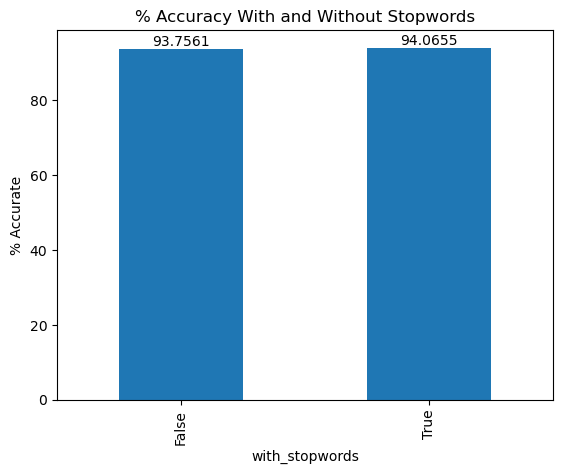

In [13]:
all_results = pd.concat([with_stopwords_table, wo_stopwords_table])

accuracy_graph = all_results.groupby('with_stopwords')['accuracy'].mean().plot.bar()
accuracy_graph.bar_label(accuracy_graph.containers[0])
plt.title('% Accuracy With and Without Stopwords')
plt.ylabel('% Accurate')

plt.show()

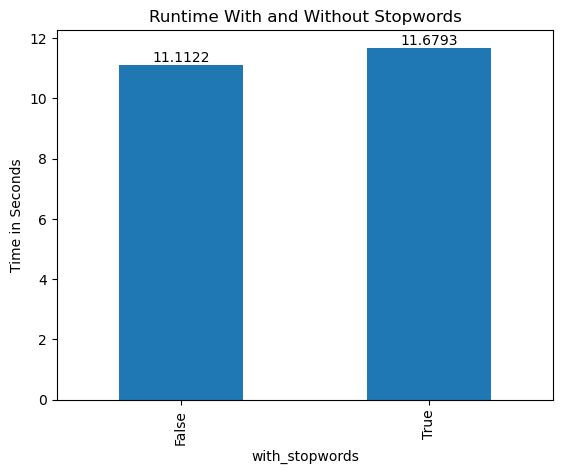

In [14]:
time_graph = all_results.groupby('with_stopwords')['time_elapsed'].mean().plot.bar()
time_graph.bar_label(time_graph.containers[0])
plt.title('Runtime With and Without Stopwords')
plt.ylabel('Time in Seconds')
plt.show()

## Step 2: Get probabilities that any one email in the training data is either spam or ham

In the labelled dataset, count the number of spam and ham emails.

$P(Spam) = \frac{Spam\,Emails}{Total\,Emails}$

$P(Ham) = \frac{Ham\,Emails}{Total\,Emails}$

## Step 3: Get the "spamicity" and "hamicity" probability of each word in the testing data email

**w** = word
<br>**vocab** = total words in dataset
<br>**spam_vocab**
<br>**wi_spam_count**

Count all unique words in the labelled dataset to get **vocab**.

Count the total number of words in labelled spam emails (ignoring uniqueness) to get **spam_vocab**.

For each word **w**, count all instances of the word in the spam emails to get **wi_spam_count**.

Calculate spamicity of each word and store the word and its spamicity in a dictionary

$P(w_{i}|Spam) = \frac{wi\_spam\_count\,+\,\alpha}{spam\_vocab\,+\,\alpha \cdot vocab}$

$\alpha$ is a coefficient that prevents a probability from being 0.


## Step 4: Calculate the "spamicity" and "hamicity" of each email

Multiply spamicities of each word together to get $\prod_{i=1}^{n}P(w_{i}|Spam)$.

Multiply that product by the probability that any email is spam.

## Step 5: Compare hamicity and spamicity scores to classify emails

## Step 6: Check accuracy of the model